## Calibration of Gaussian-Schell model beam

In [1]:
%pylab
%matplotlib inline
import SimMLA.fftpack as simfft
import SimMLA.grids   as grids
import SimMLA.fields  as fields

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


I am simulating a Gaussian Schell model beam using a technique described in [Xiao and Voelz, "Wave optics simulation approach for partial spatially coherent beams," Opt. Express 14, 6986-6992 (2006)](https://www.osapublishing.org/oe/abstract.cfm?uri=oe-14-16-6986). However, the multiplicative factors in front of the random phase screen do not seem to produce fields with the desired coherence lengths for the entire range of values of the phase screen's parameters.

This may be remedied by empirically generating several realizations of a field and computing its coherence length. We can adjust a magic number that multiplies the values of the phase screen until the desired coherence length is obtained.

## Build the dual MLA illuminator
To keep the autocorrelation calculations below to within a reasonable time, keep `subgridSize` small, like 5001 or less.

In [2]:
numLenslets = 21    # Must be odd; corresponds to the number of lenslets in one dimension
lensletSize = 500   # microns
focalLength = 13700 # microns

wavelength  = 0.642 # microns

subgridSize  = 2001 # Number of grid (or lattice) sites for a single lenslet
physicalSize = numLenslets * lensletSize # The full extent of the MLA

# dim = 1 makes the grid 1D
grid = grids.GridArray(numLenslets, subgridSize, physicalSize, wavelength, focalLength, dim = 1, zeroPad = 3)

The desired coherence length is set in `coherenceLength`. The rest of the beam is defined as described in another notebook.

In [3]:
Z0              = 376.73 # Impedance of free space, Ohms
power           = 100  # mW
beamStd         = 1000 # microns
coherenceLength = 100  # microns
fieldAmp = np.sqrt(power / 1000 * Z0 / beamStd / np.sqrt(np.pi)) # Factor of 1000 converts from mW to W

beam     = fields.GSMBeamRealization(fieldAmp, beamStd, coherenceLength, grid)

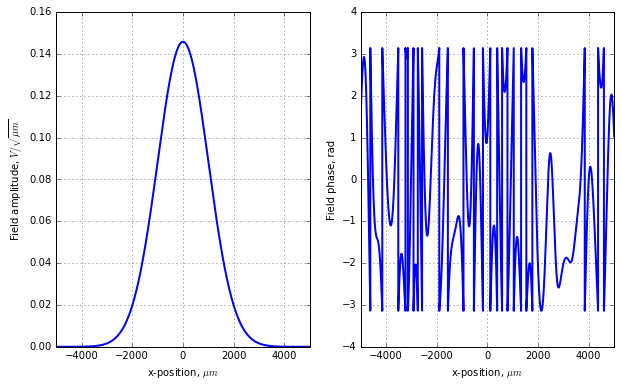

In [4]:
beamSample = beam(grid.px)

fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, sharey = False, figsize = (10, 6))
ax0.plot(grid.px, np.abs(beamSample), linewidth = 2)
ax0.set_xlim((-5000, 5000))
ax0.set_xlabel(r'x-position, $\mu m$')
ax0.set_ylabel(r'Field amplitude, $V / \sqrt{\mu m}$')
ax0.grid(True)

ax1.plot(grid.px, np.angle(beamSample), linewidth = 2)
ax1.set_xlabel(r'x-position, $\mu m$')
ax1.set_ylabel(r'Field phase, rad')
ax1.set_xlim((-5000, 5000))
ax1.grid(True)
plt.show()

## Computing the autocorrelation of the random transmittance

In this case, the phase screen is multiplying a Gaussian beam at its waist where the phase is flat, so the phase is determined entirely by the phase screen and not the beam. According to [Xiao and Voelz](https://www.osapublishing.org/oe/abstract.cfm?uri=oe-14-16-6986), the coherence length \\( \ell\_c \\) of the beam is determined by the width of the autocorrelation function of the transmittance \\( R \left( x' \right) \\). The complex coherence factor is just the \\( R \left( x' \right) \\) normalized, or \\( \mu\_{12} = \frac{R \left( x' \right)}{R \left( 0 \right)}\\). For the Gaussian Schell model beam,

$$ \left| \mu_{12} \right| = \exp \left( \frac{-x'^2}{\ell_c^2} \right) $$

which is a Gaussian with a standard deviation of \\( \sigma = \frac{\ell_c}{\sqrt{2}} \\) and a FWHM of approximately \\( 2.3548 \sigma \\).

The generation of the phase screen depends on two parameters, \\( \sigma_r \\) and \\(\sigma_f \\). Qualitatively, these parameters describe the strength of the phase variations and the correlation length of the phase screen, respectively. However, they are related to beam's coherence length in a non-trivial way only when

$$ \frac{\sigma_r^2}{2 \pi \sigma_f^2} \gg 1 $$

(Note that the notation used here follows Voelz's book rather than the article. In the book, \\( \sigma_f \\) absorbs a factor of \\( \sqrt{2} \\).) When this relationship is not satisfied, we can empirically determine the coherence length by computing several transmittance function realizations, cross-correlating them, finding their or standard deviation, and averaging the result. If the resulting coherence length does not match the desired one, we then multiply the transmittance by a constant factor and repeat the process until the desired coherence length is obtained.

The multiplicative factor is a magic number located in the `_applyMask()` routine of `SimMLA.fields`.

In [5]:
# Prepare the Gaussian curve fit
from scipy.optimize import curve_fit as cf
def Gaussian(x, *p):
    mean, cohLength = p
    
    return np.exp(-(x - mean)**2 / cohLength**2)

initGuess = [0, 100]

In [6]:
# Compute the phase screen transmittance and its autocorrelation
t = np.exp(1j * np.angle(beamSample))

zeroSize = np.floor(t.size / 2)
tZeroPad = np.hstack((np.zeros(zeroSize), t, np.zeros(zeroSize)))

# Normalize inputs for correct cross-correlation
t = (t - np.mean(t)) / (np.std(t) * len(t))
tZeroPad = (tZeroPad - np.mean(tZeroPad)) /  np.std(tZeroPad)

R = np.correlate(t, tZeroPad, mode = 'valid')
R = np.abs(R / np.max(R))

/home/kmdouglass/anaconda3/envs/lensletArrays/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [7]:
# Fit a Gaussian to R and find the std. dev.
popt, _ = cf(Gaussian, grid.px, R, p0 = initGuess)

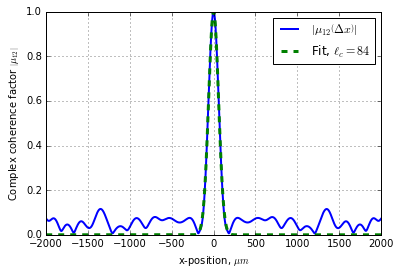

In [8]:
plt.plot(grid.px, np.abs(R / np.max(R)), linewidth = 2, label = r'$\left| \mu_{12} \left( \Delta x \right) \right|$')
plt.plot(grid.px, Gaussian(grid.px, *popt), '--', linewidth = 3, label = r'Fit, $\ell_c = {0:.0f}$'.format(popt[1]))
plt.xlim((-2000, 2000))
plt.ylim((0, 1))
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel(r'Complex coherence factor $\left| \mu_{12} \right|$')
plt.grid(True)
plt.legend()
plt.show()

Let's now repeat this procedure for a number of realizations of the phase screen and take the average of the resulting coherence lengths.

In [ ]:
%%time
nIter          = 25 # iterations
cohLengthArray = np.zeros(nIter) # Results of the fits
for ctr in range(nIter):    
    # Create a new realization of the beam
    beamSample = beam(grid.px)
    
    # Compute the phase screen transmittance and its autocorrelation
    t = np.exp(1j * np.angle(beamSample))

    zeroSize = np.floor(t.size / 2)
    tZeroPad = np.hstack((np.zeros(zeroSize), t, np.zeros(zeroSize)))

    # Normalize inputs for correct cross-correlation
    t = (t - np.mean(t)) / (np.std(t) * len(t))
    tZeroPad = (tZeroPad - np.mean(tZeroPad)) /  np.std(tZeroPad)

    R = np.correlate(t, tZeroPad, mode = 'valid')
    R = np.abs(R / np.max(R))
    
    # Find the coherence length from a fit to R
    popt, _ = cf(Gaussian, grid.px, R, p0 = initGuess)
    
    # Save the results to the array
    cohLengthArray[ctr] = popt[1]

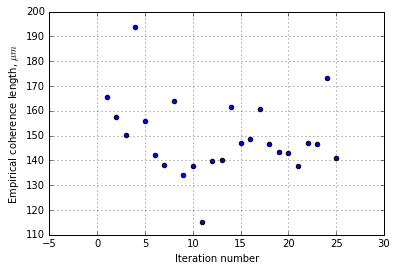

In [11]:
plt.scatter(np.arange(nIter) + 1, cohLengthArray)
plt.xlabel('Iteration number')
plt.ylabel(r'Empirical coherence length, $\mu m$')
plt.grid(True)
plt.show()

In [12]:
print('Mean: {0}'.format(np.mean(cohLengthArray)))
print('Std. Err.: {0}'.format(np.std(cohLengthArray) / np.sqrt(nIter)))

Mean: 149.254144315604
Std. Err.: 2.9970968328094694


## Results
### Test 1
**Multiplicative factor:** 0.01

**Input \\(\ell_c \\):** 100 microns

**Empirical \\(\ell_c \\):** 320 +/- 7 microns

### Test 2
**Multiplicative factor:** 0.03

**Input \\(\ell_c \\):** 100 microns

**Empirical \\(\ell_c \\):** 149 +/- 3 microns

### Test 3
**Multiplicative factor:** 0.042

**Input \\(\ell_c \\):** 100 microns

**Empirical \\(\ell_c \\):** 

In [10]:
# Compute the power in the simulated beam and compare it to the input.
# These should be equal.
from scipy.integrate import simps
integratedPower = simps(np.abs(beam(grid.px))**2, grid.px) * 1000 / Z0

print('The total power in the beam is: {0:.4f}'.format(integratedPower))
print('The input power in the beam is: {0:.4f}'.format(power))

The total power in the beam is: 100.0000
The input power in the beam is: 100.0000


## Propagate the Gaussian through the illuminator
Propagating this beam through the MLA-based illuminator is the same as for the plane wave case. First we find the field immediately after the second MLA.

In [11]:
%%time
# Compute the interpolated fields
# Linear interpolation is used for speed
interpMag, interpPhase = simfft.fftSubgrid(beam, grid)

fObj        = 3300 # microns
newGridSize = subgridSize * numLenslets # microns

# Upsample grid by an odd factor to reduce rippling
newGrid = grids.Grid(5*newGridSize, 5*physicalSize, wavelength, fObj, dim = 1)
field   = np.zeros(newGrid.gridSize)

# For each interpolated magnitude and phase corresponding to a lenslet
# 1) Compute the full complex field
# 2) Sum it with the other complex fields
for currMag, currPhase in zip(interpMag, interpPhase):
    fieldMag   = currMag(newGrid.px)
    fieldPhase = currPhase(newGrid.px)
    
    currField = fieldMag * np.exp(1j * fieldPhase)
    field     = field + currField

CPU times: user 1.01 s, sys: 8 ms, total: 1.02 s
Wall time: 1.01 s


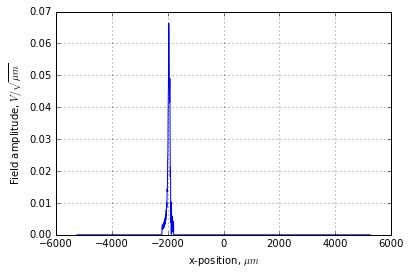

In [12]:
# Check that we've successfully computed the Fourier transform of a lenslet.
m = 6 # lenslet index, integers between [0, numLenslets - 1]
plt.plot(grid.px, np.abs(interpMag[m](grid.px) * np.exp(1j * interpPhase[m](grid.px))))
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel(r'Field amplitude, $V / \sqrt{\mu m}$')
plt.grid(True)
plt.show()

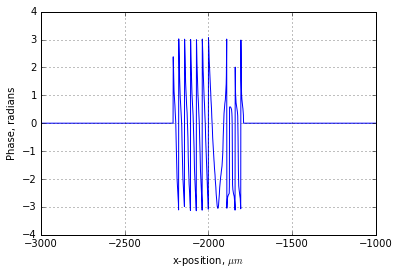

In [13]:
# Check that we've successfully computed the Fourier transform of a lenslet.
m = 6 # lenslet index, integers between [0, numLenslets - 1]
plt.plot(grid.px, np.angle(interpMag[m](grid.px) * np.exp(1j * interpPhase[m](grid.px))))
plt.xlim((-3000,-1000))
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel('Phase, radians')
plt.grid(True)
plt.show()

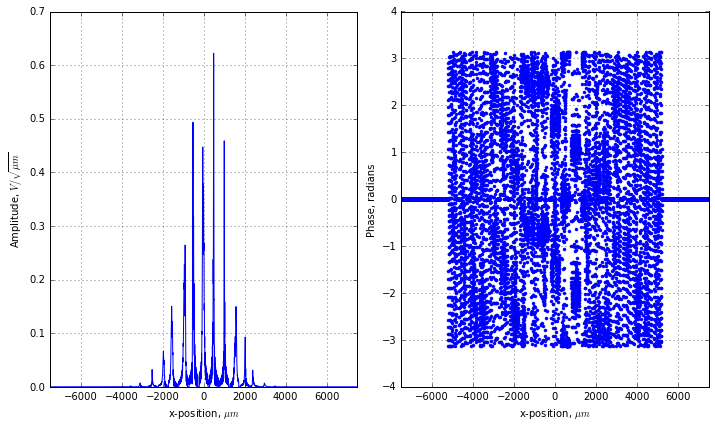

In [14]:
# Plot the field immediately after the second MLA
fig, (ax0, ax1) = plt.subplots(nrows = 1,
                               ncols = 2,
                               sharex = True,
                               sharey = False,
                               figsize = (10,6))

ax0.plot(newGrid.px, np.abs(field))
ax0.set_xlim((-7500, 7500))
ax0.set_xlabel(r'x-position, $\mu m$')
ax0.set_ylabel(r'Amplitude, $V / \sqrt{\mu m}$')
ax0.grid()

ax1.plot(newGrid.px, np.angle(field), '.')
ax1.set_xlabel(r'x-position, $\mu m$')
ax1.set_ylabel('Phase, radians')
ax1.grid()

plt.tight_layout()
plt.show()

In [15]:
# Is power still conserved?
# No scaling factor is necessary because the angular spectrum was only shifted in phase.
powerBFPIn = simps(np.abs(field)**2, newGrid.px) / Z0 * 1000
print('Power before the aperture in the BFP: {0:.4f} mW'.format(powerBFPIn))

Power before the aperture in the BFP: 99.2011 mW


Now that we have the field after the second MLA, we propagate it to the objective's back aperture, truncate it, and finally compute the field on the sample.

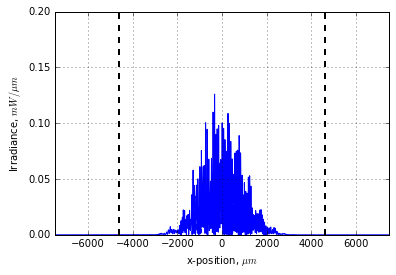

In [16]:
propDistance = 20000 # Approximate distance between second MLA and objective's back focal plane, microns
u2 = simfft.fftPropagate(field, newGrid, 20000)

bfpDiam = 2 * 1.4 * 3300 # BFP diameter, 2 * NA * f_OBJ
yMax = 0.2
u2Prime = u2
u2Prime[np.logical_or(newGrid.px < -bfpDiam / 2, newGrid.px > bfpDiam / 2)] = 0.0

# Plot the field in the objective's back focal plane without the aperture
plt.plot(newGrid.px, np.abs(u2Prime)**2 / Z0 * 1000)
plt.plot([-bfpDiam / 2, -bfpDiam / 2], [0, yMax], '--k', linewidth = 2, label = 'Back aperture')
plt.plot([bfpDiam / 2, bfpDiam / 2],   [0, yMax], '--k', linewidth = 2)
plt.xlim((-7500, 7500))
plt.ylim((0, yMax))
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel(r'Irradiance, $mW / \mu m$')
plt.grid(True)
plt.show()

In [17]:
# Is power still conserved?
# No scaling factor is necessary because the angular spectrum was only shifted in phase.
powerBFPIn = simps(np.abs(u2)**2, newGrid.px) / Z0 * 1000
print('Power before the aperture in the BFP: {0:.4f} mW'.format(powerBFPIn))

Power before the aperture in the BFP: 99.1584 mW


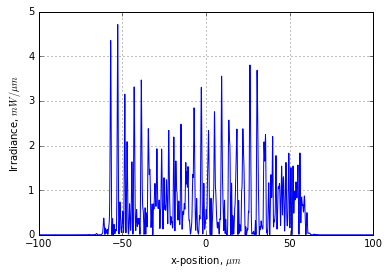

Power delivered to sample: 99.1603 mW


In [18]:
# Sample plane irradiance including limiting aperture in the BFP
scalingFactor = newGrid.physicalSize / (newGrid.gridSize - 1) / np.sqrt(newGrid.wavelength * newGrid.focalLength)
F             = scalingFactor * np.fft.fftshift(np.fft.fft(np.fft.ifftshift(u2Prime)))

plt.plot(newGrid.pX, np.abs(F)**2 / Z0 * 1000)
plt.xlim((-100, 100))
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel(r'Irradiance, $mW / \mu m$')
plt.grid(True)
plt.show()

powerSample = simps(np.abs(F)**2, newGrid.pX) / Z0 * 1000
print('Power delivered to sample: {0:.4f} mW'.format(powerSample))